In [1]:
### Auxiliary Functions
import matplotlib.pyplot as plt

def line_chart(ax: plt.Axes, xvalues: list, yvalues: list, title: str, xlabel: str, ylabel: str, percentage=False):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.plot(xvalues, yvalues)

def multiple_line_chart(ax: plt.Axes, xvalues: list, yvalues: dict, title: str, xlabel: str, ylabel: str, percentage=False):
    legend: list = []
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend, loc='best', fancybox = True, shadow = True)   
    
def plot_roc_chart(ax: plt.Axes, models: dict, tstX, tstY, target: str='class'):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s'%target)
    ax.plot([0, 1], [0, 1], color='navy', label='random', linestyle='--')    
    for clf in models:
        scores = models[clf].predict_proba(tstX)[:,1]
        fpr, tpr, _ = metrics.roc_curve(tstY, scores, 'positive')
        roc_auc = metrics.roc_auc_score(tstY, scores)
        ax.plot(fpr, tpr, label='%s (auc=%0.2f)' %(clf, roc_auc))
    ax.legend(loc="lower center")


# Description

##### The goal of this project is to apply data science techniques to discover information in two distinct datasets. The first dataset describes various speech signal processing algorithms applied to the speech recordings of Parkinson's Disease (PD) patients to extract clinically useful information for PD assessment. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold

data = pd.read_csv('pd_speech_features.csv', sep=',')

data.shape

(756, 755)

In [3]:
cat_vars = data.select_dtypes(include='category')
cat_vars.columns.size

0

In [4]:
num_vars = data.select_dtypes(include='number')
num_vars.columns.size

755

In [5]:
null_vars = {}
for var in data:
    nas = data[var].isna().sum()
    if nas > 0:
        null_vars[var] = nas
print(len(null_vars))

0


In [6]:
data.head(6)

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1
5,1,0,0.50780,0.78744,0.65451,226,221,0.007631,0.002696,0.00783,...,4.8025,5.0734,7.0166,5.9966,5.2065,7.4246,3.4153,3.5046,3.2250,1


##### The dataset has 756 records and 755 attributes, all numeric, and does not have any null values.

### Reducing Sample Size

##### This dataset describes three measurements for each patient, so we apply the mean of those samples to have one sample per patient.

In [7]:
data = data.groupby('id').mean().reset_index()
data.shape

(252, 755)

In [8]:
data.head(6)

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1.0,0.823387,0.696370,0.567250,235.333333,234.333333,0.008220,0.000073,0.001963,...,1.561733,2.862000,12.293333,9.717500,9.055300,6.259100,4.021533,4.164333,22.961700,1.0
1,1,0.0,0.415637,0.793993,0.592453,213.333333,211.000000,0.008884,0.001849,0.005790,...,4.918567,4.827133,6.117633,8.599667,5.737233,7.933133,5.490533,4.941833,4.467233,1.0
2,2,1.0,0.801973,0.619967,0.520563,319.333333,318.333333,0.006041,0.000104,0.002217,...,41.129400,31.201933,14.584467,5.446800,3.462000,4.772067,9.176633,11.848100,5.552367,1.0
3,3,0.0,0.828707,0.626097,0.537183,493.000000,492.000000,0.003913,0.000042,0.000757,...,1.677633,1.908400,2.842167,3.493867,3.282433,3.085267,3.184433,4.032933,22.773633,1.0
4,4,0.0,0.831287,0.779397,0.726717,362.666667,361.666667,0.005622,0.002023,0.003593,...,4.104600,4.285233,2.953200,2.799933,2.645100,2.811367,7.268333,13.338833,63.766900,1.0
5,5,1.0,0.822520,0.622083,0.357660,284.000000,283.000000,0.006815,0.000046,0.000940,...,25.482500,29.795367,26.472767,43.983700,54.324967,49.879867,43.996667,37.834733,73.894367,1.0


# Classification

##### For the PD dataset, the target variable is 'class' and it is binary.

### Preprocessing

### Training Strategy

In [9]:
X = data.drop(columns=['class'])
y = data['class'].values

In [10]:
# Hold-Out 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=12, 
                                                    stratify=y)

### KNN

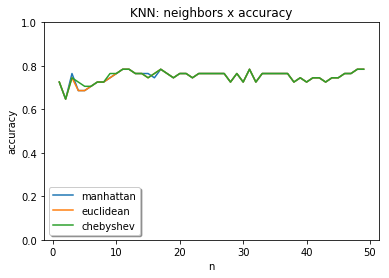

In [11]:
n_neighbors = range(1,50)
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
for d in dist:
    accuracy_values = []
    for n in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        accuracy_values.append(metrics.accuracy_score(y_test, y_predict))
    values[d] = accuracy_values
plt.figure()
multiple_line_chart(plt.gca(), n_neighbors, values, 'KNN: neighbors x accuracy', 'n', 'accuracy', percentage=True)
plt.show()

In [12]:
def average(lst): 
    return sum(lst) / len(lst) 

for d in values:
    print(round(average(values[d]),2))

0.75
0.75
0.75


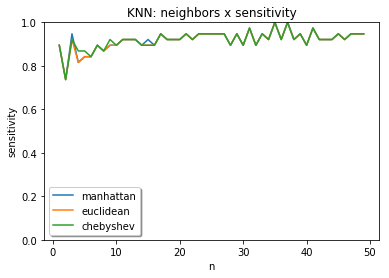

In [13]:
n_neighbors = range(1,50)
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
for d in dist:
    accuracy_values = []
    for n in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        accuracy_values.append(metrics.recall_score(y_test, y_predict))
    values[d] = accuracy_values
plt.figure()
multiple_line_chart(plt.gca(), n_neighbors, values, 'KNN: neighbors x sensitivity', 'n', 'sensitivity', percentage=True)
plt.show()

In [14]:
def average(lst): 
    return sum(lst) / len(lst) 

for d in values:
    print(round(average(values[d]),2))

0.92
0.92
0.92


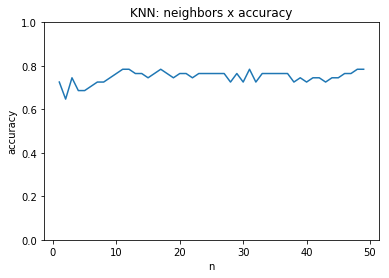

In [18]:
n_neighbors = range(1,50)
values = {}
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, metric='euclidean')
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    values[n] = metrics.accuracy_score(y_test, y_predict)
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(), 'KNN: neighbors x accuracy', 'n', 'accuracy', percentage=True)
plt.show()

In [19]:
max(zip(values.values(), values.keys()))

(0.7843137254901961, 49)

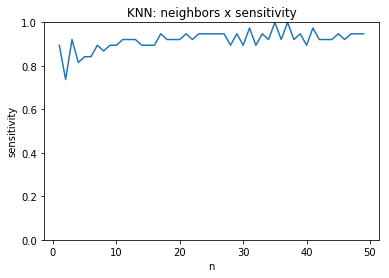

In [22]:
n_neighbors = range(1,50)
values = {}
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, metric='euclidean')
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    values[n] = metrics.recall_score(y_test, y_predict)
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(), 'KNN: neighbors x sensitivity', 'n', 'sensitivity', percentage=True)
plt.show()

In [23]:
max(zip(values.values(), values.keys()))

(1.0, 37)

##### The distance function doesn't change the accuracy of the model, so we chose the euclidean distance. The highest accuracy value corresponds to a model of 30 neighbors; and The highest sensitivity value corresponds to a model of 35 neighbors.

In [24]:
knn = KNeighborsClassifier(n_neighbors=49, metric='euclidean')
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
    
print("Neighbors: 49")
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_predict),2))
print("Precision: ", round(metrics.precision_score(y_test, y_predict),2))
print("Sensitivity: ", round(metrics.recall_score(y_test, y_predict),2))
print("F1-score: ", round(metrics.f1_score(y_test, y_predict),2))

Neighbors: 49
Accuracy:  0.78
Precision:  0.8
Sensitivity:  0.95
F1-score:  0.87


In [25]:
knn = KNeighborsClassifier(n_neighbors=37, metric='euclidean')
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
    
print("Neighbors: 37")
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_predict),2))
print("Precision: ", round(metrics.precision_score(y_test, y_predict),2))
print("Sensitivity: ", round(metrics.recall_score(y_test, y_predict),2))
print("F1-score: ", round(metrics.f1_score(y_test, y_predict),2))

Neighbors: 37
Accuracy:  0.76
Precision:  0.76
Sensitivity:  1.0
F1-score:  0.86


In [ ]:
#knn = KNeighborsClassifier(n_neighbors=30, metric='manhattan')
#score_array = []
#for train_index, test_index in skf.split(X,y):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    knn.fit(X_train, y_train)
#    y_predict = knn.predict(X_test)
#    score_array.append(metrics.accuracy_score(y_test, y_predict))

In [48]:
# Confusion Matrix
import itertools
import matplotlib.pyplot as plt
CMAP = plt.cm.Reds

def plot_confusion_matrix(ax: plt.Axes, cnf_matrix: np.ndarray, classes_names: list, normalize: bool = False):
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=CMAP)
    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), horizontalalignment="center")

<Figure size 432x288 with 0 Axes>

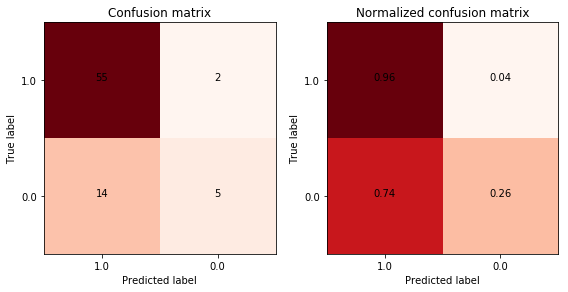

In [54]:
knn = KNeighborsClassifier(n_neighbors=30, metric='euclidean')
knn.fit(X_train, y_train)

labels: np.ndarray = pd.unique(y)
y_predict: np.ndarray = knn.predict(X_test)
cnf_mtx: np.ndarray = metrics.confusion_matrix(y_test, y_predict, labels)

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(axs[0,0], cnf_mtx, labels)
plot_confusion_matrix(axs[0,1], metrics.confusion_matrix(y_test, y_predict, labels), labels, normalize=True)
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

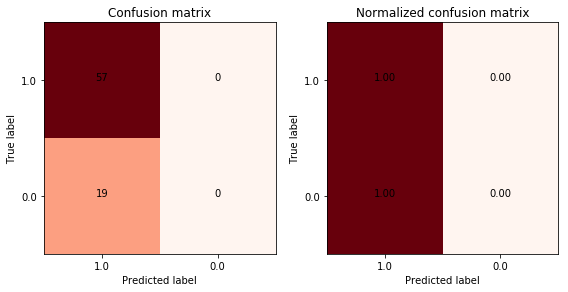

In [53]:
knn = KNeighborsClassifier(n_neighbors=35, metric='euclidean')
knn.fit(X_train, y_train)

labels: np.ndarray = pd.unique(y)
y_predict: np.ndarray = knn.predict(X_test)
cnf_mtx: np.ndarray = metrics.confusion_matrix(y_test, y_predict, labels)

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(axs[0,0], cnf_mtx, labels)
plot_confusion_matrix(axs[0,1], metrics.confusion_matrix(y_test, y_predict, labels), labels, normalize=True)
plt.tight_layout()
plt.show()

# Unsupervised Learning

##### Since this is an unsupervised technique we removed the target column, 'class'. The column 'id' is also irrelevant for this analysis.

In [100]:
data_unsup = data.copy()
data_unsup.shape
data_unsup.head(5)

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1.0,0.823387,0.696370,0.567250,235.333333,234.333333,0.008220,0.000073,0.001963,...,1.561733,2.862000,12.293333,9.717500,9.055300,6.259100,4.021533,4.164333,22.961700,1.0
1,1,0.0,0.415637,0.793993,0.592453,213.333333,211.000000,0.008884,0.001849,0.005790,...,4.918567,4.827133,6.117633,8.599667,5.737233,7.933133,5.490533,4.941833,4.467233,1.0
2,2,1.0,0.801973,0.619967,0.520563,319.333333,318.333333,0.006041,0.000104,0.002217,...,41.129400,31.201933,14.584467,5.446800,3.462000,4.772067,9.176633,11.848100,5.552367,1.0
3,3,0.0,0.828707,0.626097,0.537183,493.000000,492.000000,0.003913,0.000042,0.000757,...,1.677633,1.908400,2.842167,3.493867,3.282433,3.085267,3.184433,4.032933,22.773633,1.0
4,4,0.0,0.831287,0.779397,0.726717,362.666667,361.666667,0.005622,0.002023,0.003593,...,4.104600,4.285233,2.953200,2.799933,2.645100,2.811367,7.268333,13.338833,63.766900,1.0


In [101]:
data_unsup = data_unsup.drop(columns=['class', 'id'])
data_unsup.head(5)

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
0,1.0,0.823387,0.696370,0.567250,235.333333,234.333333,0.008220,0.000073,0.001963,0.000016,...,1.546500,1.561733,2.862000,12.293333,9.717500,9.055300,6.259100,4.021533,4.164333,22.961700
1,0.0,0.415637,0.793993,0.592453,213.333333,211.000000,0.008884,0.001849,0.005790,0.000050,...,7.049367,4.918567,4.827133,6.117633,8.599667,5.737233,7.933133,5.490533,4.941833,4.467233
2,1.0,0.801973,0.619967,0.520563,319.333333,318.333333,0.006041,0.000104,0.002217,0.000013,...,1.581967,41.129400,31.201933,14.584467,5.446800,3.462000,4.772067,9.176633,11.848100,5.552367
3,0.0,0.828707,0.626097,0.537183,493.000000,492.000000,0.003913,0.000042,0.000757,0.000003,...,2.382533,1.677633,1.908400,2.842167,3.493867,3.282433,3.085267,3.184433,4.032933,22.773633
4,0.0,0.831287,0.779397,0.726717,362.666667,361.666667,0.005622,0.002023,0.003593,0.000021,...,3.881267,4.104600,4.285233,2.953200,2.799933,2.645100,2.811367,7.268333,13.338833,63.766900


### Preprocessing

##### We are dealing with a large dataset in an unsupevised setting, so features with low-variance will be removed.

In [102]:
#from sklearn.feature_selection import VarianceThreshold

#selector = VarianceThreshold(data_unsup.var().mean())
#selector.fit(data_unsup)
#sel_data = data[data.columns[selector.get_support(indices=True)]]
#sel_data.shape

In [103]:
#sel_data.head()

In [104]:
sel_data = data_unsup[['gender','PPE','DFA','RPDE','numPulses','meanPeriodPulses','meanIntensity']].copy()

In [105]:
sel_data.head()

,gender,PPE,DFA,RPDE,numPulses,meanPeriodPulses,meanIntensity
0,1.0,0.823387,0.696370,0.567250,235.333333,0.008220,70.693680
1,0.0,0.415637,0.793993,0.592453,213.333333,0.008884,79.035677
2,1.0,0.801973,0.619967,0.520563,319.333333,0.006041,76.964361
3,0.0,0.828707,0.626097,0.537183,493.000000,0.003913,75.634650
4,0.0,0.831287,0.779397,0.726717,362.666667,0.005622,62.427726


##### Normalization

In [106]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scale_data = scaler.fit_transform(sel_data)
scale_data = pd.DataFrame(scale_data, columns=sel_data.columns)

In [107]:
scale_data.head()

,gender,PPE,DFA,RPDE,numPulses,meanPeriodPulses,meanIntensity
0,1.0,0.916232,0.475707,0.590235,0.284974,0.593576,0.684591
1,0.0,0.182314,0.806469,0.630075,0.242228,0.673119,0.897642
2,1.0,0.877689,0.216841,0.516437,0.448187,0.332076,0.844742
3,0.0,0.925807,0.237611,0.542708,0.785622,0.076828,0.810781
4,0.0,0.930451,0.757013,0.842307,0.532383,0.281800,0.473482


### Association Rule Mining - Equal-width discretization

In [84]:
for col in scale_data:
    if col not in ['gender']:
        scale_data[col] = pd.cut(scale_data[col],5,labels=['1','2','3','4','5'])
scale_data.head()

,gender,PPE,DFA,RPDE,numPulses,meanPeriodPulses,meanIntensity
0,1.0,5,3,3,2,3,4
1,0.0,1,5,4,2,4,5
2,1.0,5,2,3,3,2,5
3,0.0,5,2,3,4,1,5
4,0.0,5,4,5,3,2,3


In [85]:
dummylist = []
for att in scale_data:
    dummylist.append(pd.get_dummies(scale_data[[att]]))
dummi_data = pd.concat(dummylist, axis=1)
dummi_data.head(5)

,gender,PPE_1,PPE_2,PPE_3,PPE_4,PPE_5,DFA_1,DFA_2,DFA_3,DFA_4,...,meanPeriodPulses_1,meanPeriodPulses_2,meanPeriodPulses_3,meanPeriodPulses_4,meanPeriodPulses_5,meanIntensity_1,meanIntensity_2,meanIntensity_3,meanIntensity_4,meanIntensity_5
0,1.0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1.0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0.0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [86]:
dummi_data.shape

(252, 31)

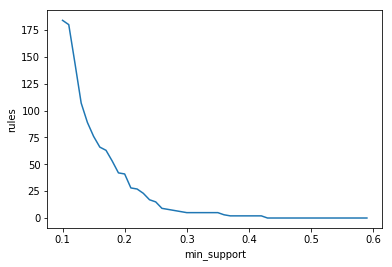

In [87]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

minsup = np.arange(0.1,0.6,0.01)
values = {}
for s in minsup:
    frequent_itemsets = apriori(dummi_data, min_support=s, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    values[s] = len(rules.index)
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(),'', 'min_support', 'rules', percentage=False)
plt.show() 

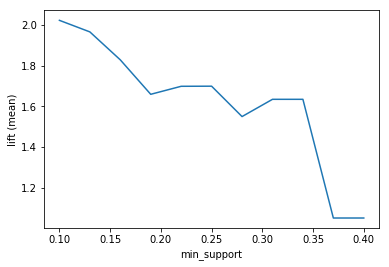

In [97]:
minsup = np.arange(0.1,0.6,0.03)
values = {}
for s in minsup:
    frequent_itemsets = apriori(dummi_data, min_support=s, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    values[s] = rules['lift'].mean()
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(),'', 'min_support', 'lift (mean)', percentage=False)
plt.show() 

In [136]:
minsup = 0.15
frequent_itemsets = apriori(dummi_data, min_support=minsup, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
rules['lift'].mean()

2.1806315334804345

### Association Rule Mining - Equal-frequency discretization

In [108]:
for col in scale_data:
    if col not in ['gender']:
        scale_data[col] = pd.qcut(scale_data[col],5,labels=['1','2','3','4','5'])
scale_data.head()

,gender,PPE,DFA,RPDE,numPulses,meanPeriodPulses,meanIntensity
0,1.0,4,3,4,1,5,2
1,0.0,1,5,4,1,5,5
2,1.0,3,1,3,3,3,3
3,0.0,4,1,4,5,1,3
4,0.0,5,5,5,4,2,1


In [109]:
dummylist = []
for att in scale_data:
    dummylist.append(pd.get_dummies(scale_data[[att]]))
dummi_data = pd.concat(dummylist, axis=1)
dummi_data.head(5)

,gender,PPE_1,PPE_2,PPE_3,PPE_4,PPE_5,DFA_1,DFA_2,DFA_3,DFA_4,...,meanPeriodPulses_1,meanPeriodPulses_2,meanPeriodPulses_3,meanPeriodPulses_4,meanPeriodPulses_5,meanIntensity_1,meanIntensity_2,meanIntensity_3,meanIntensity_4,meanIntensity_5
0,1.0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
1,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1.0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0.0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [110]:
dummi_data.shape

(252, 31)

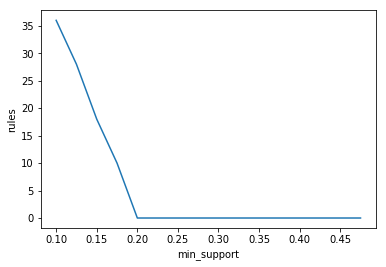

In [113]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

minsup = np.arange(0.1,0.5,0.025)
values = {}
for s in minsup:
    frequent_itemsets = apriori(dummi_data, min_support=s, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    values[s] = len(rules.index)
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(),'', 'min_support', 'rules', percentage=False)
plt.show() 

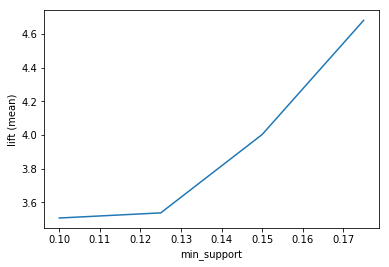

In [119]:
minsup = np.arange(0.1,0.5,0.025)
values = {}
for s in minsup:
    frequent_itemsets = apriori(dummi_data, min_support=s, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    values[s] = rules['lift'].mean()
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(),'', 'min_support', 'lift (mean)', percentage=False)
plt.show() 